<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/basics_04_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://arxiv.org/abs/1502.03167
- Hidden layer activation should not be too small or too large, best would be to be centered around 0 and have a std about ~ 1
- Idea: normalize the hidden state  to be gausian!

In [1]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-06-24 10:53:16--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.006s  

2025-06-24 10:53:16 (37.1 MB/s) - ‘names.txt’ saved [228145/228145]



In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
# build vocab and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd ** block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

In [13]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [14]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3022
  10000/ 200000: 2.2146
  20000/ 200000: 2.2256
  30000/ 200000: 2.4092
  40000/ 200000: 1.9429
  50000/ 200000: 2.4373
  60000/ 200000: 2.4328
  70000/ 200000: 2.1334
  80000/ 200000: 2.2828
  90000/ 200000: 2.1979
 100000/ 200000: 1.9310
 110000/ 200000: 2.2433
 120000/ 200000: 1.9741
 130000/ 200000: 2.5431
 140000/ 200000: 2.4108
 150000/ 200000: 2.2106
 160000/ 200000: 1.8690
 170000/ 200000: 1.7443
 180000/ 200000: 1.9653
 190000/ 200000: 1.8745


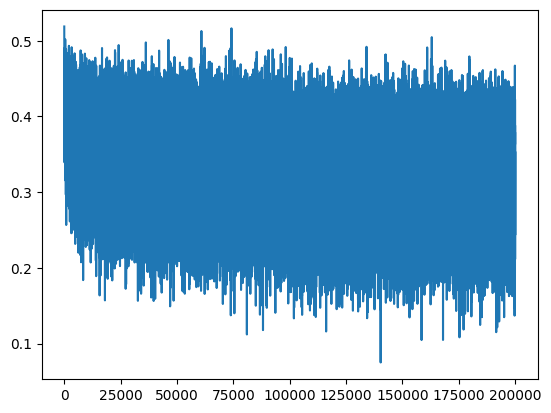

In [15]:
plt.plot(lossi)

In [10]:
@torch.no_grad()
def calculate_loss(X, Y):
  emb = C[X]
  embcat =  emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

In [16]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")

Training loss: 2.086503028869629
Dev loss: 2.1310949325561523
